### Mutual information score - Feature Selection

In [2300]:
from warnings import filterwarnings
filterwarnings('ignore')

### Read the dataset

In [2301]:
import pandas as pd
df = pd.read_csv('train_titanic.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [2302]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [2303]:
m = df.isna().sum()
m[m>0]

Age         177
Cabin       687
Embarked      2
dtype: int64

### Seperate X and Y

In [2304]:
X = df.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin', 'Survived'])
Y = df[['Survived']]

In [2305]:
X.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22.0,1,0,7.2500,S
1,1,female,38.0,1,0,71.2833,C
2,3,female,26.0,0,0,7.9250,S
3,1,female,35.0,1,0,53.1000,S
4,3,male,35.0,0,0,8.0500,S


In [2306]:
Y.head()

,Survived
0,0
1,1
2,1
3,1
4,0


### Cat con seperation for X

In [2307]:
cat = list(X.columns[X.dtypes=='object'])
con = list(X.columns[X.dtypes!='object'])

In [2308]:
cat

['Sex', 'Embarked']

### Create a pipeline for feature selection

1.Use Ordinal encoder for Cat features

In [2309]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer

In [2310]:
num_pipe1 = Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                            ('scaler', StandardScaler())])

In [2311]:
cat_pipe1 = Pipeline(steps=[('impute', SimpleImputer(strategy='most_frequent')),
                            ('ordinal', OrdinalEncoder())])

In [2312]:
pre1 = ColumnTransformer([('num', num_pipe1, con),
                          ('cat', cat_pipe1, cat)]).set_output(transform='pandas')

In [2313]:
pre1

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']),
                                ('cat',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ordinal',
                                                  OrdinalEncoder())]),
                                 ['Sex', 'Embarked'])])

In [2314]:
X_pre = pre1.fit_transform(X)
X_pre.head()

,num__Pclass,num__Age,num__SibSp,num__Parch,num__Fare,cat__Sex,cat__Embarked
0,0.827377,-0.565736,0.432793,-0.473674,-0.502445,1.0,2.0
1,-1.566107,0.663861,0.432793,-0.473674,0.786845,0.0,0.0
2,0.827377,-0.258337,-0.474545,-0.473674,-0.488854,0.0,2.0
3,-1.566107,0.433312,0.432793,-0.473674,0.420730,0.0,2.0
4,0.827377,0.433312,-0.474545,-0.473674,-0.486337,1.0,2.0


### Perform feature selection with mutual information scores

In [2315]:
from sklearn.feature_selection import mutual_info_classif
mi = mutual_info_classif(X_pre, Y)
mi

array([0.03505593, 0.03670684, 0.02636697, 0.02300065, 0.12646176,
       0.1424089 , 0.        ])

In [2316]:
mi = pd.Series(mi)
mi.index = X_pre.columns
mi = mi.sort_values(ascending=False)
mi

cat__Sex         0.142409
num__Fare        0.126462
num__Age         0.036707
num__Pclass      0.035056
num__SibSp       0.026367
num__Parch       0.023001
cat__Embarked    0.000000
dtype: float64

<Axes: title={'center': 'Mutual Information Scores'}>

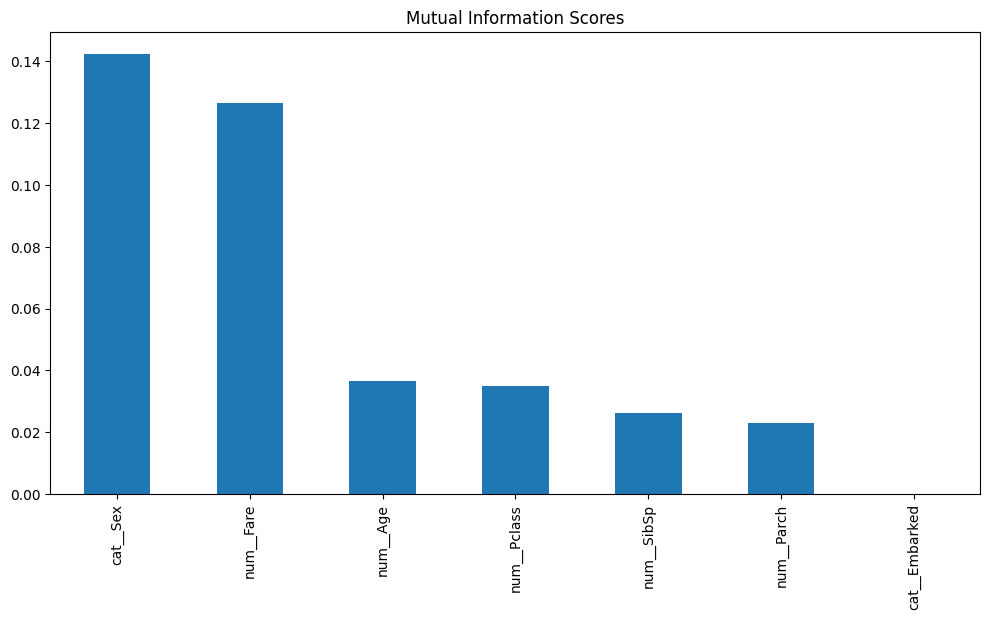

In [2317]:
mi.plot(kind='bar', title='Mutual Information Scores', figsize=(12, 6))

### Select top 4 feature

In [2318]:
from sklearn.feature_selection import SelectKBest
sel = SelectKBest(mutual_info_classif, k=4)
sel.fit(X_pre, Y)
sel_cols = sel.get_feature_names_out()
sel_cols

array(['num__Pclass', 'num__SibSp', 'num__Fare', 'cat__Sex'], dtype=object)

### Get the orignal column names

In [2319]:
sel_cols[0].split('__')

['num', 'Pclass']

In [2320]:
sel_cols[0].split('__')[1]

'Pclass'

In [2321]:
imp_cols = []
for i in sel_cols:
    s = i.split('__')[1]
    imp_cols.append(s)

In [2322]:
imp_cols

['Pclass', 'SibSp', 'Fare', 'Sex']

In [2323]:
X_imp = X[imp_cols]
X_imp

,Pclass,SibSp,Fare,Sex
0,3,1,7.2500,male
1,1,1,71.2833,female
2,3,0,7.9250,female
3,1,1,53.1000,female
4,3,0,8.0500,male
...,...,...,...,...
886,2,0,13.0000,male
887,1,0,30.0000,female
888,3,1,23.4500,female
889,1,0,30.0000,male


### Sepearate cat and con for for selected columns

In [2324]:
cat_sel = list(X_imp.columns[X_imp.dtypes=='object'])
con_sel = list(X_imp.columns[X_imp.dtypes!='object'])

In [2325]:
cat_sel

['Sex']

In [2326]:
con_sel

['Pclass', 'SibSp', 'Fare']

### Create a final preprocessing pipeline

cat - OneHotEncoder

In [2327]:
from sklearn.preprocessing import OneHotEncoder

In [2328]:
num_pipe2 = Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                            ('scaler', StandardScaler())])

In [2329]:
cat_pipe2 = Pipeline(steps=[('impute', SimpleImputer(strategy='most_frequent')),
                            ('OHE', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

In [2330]:
pre2 = ColumnTransformer([('num', num_pipe2, con_sel),
                          ('cat', cat_pipe2, cat_sel)]).set_output(transform='pandas')

In [2331]:
X_sel_pre = pre2.fit_transform(X_imp)
X_sel_pre.head()

,num__Pclass,num__SibSp,num__Fare,cat__Sex_female,cat__Sex_male
0,0.827377,0.432793,-0.502445,0.0,1.0
1,-1.566107,0.432793,0.786845,1.0,0.0
2,0.827377,-0.474545,-0.488854,1.0,0.0
3,-1.566107,0.432793,0.420730,1.0,0.0
4,0.827377,-0.474545,-0.486337,0.0,1.0


### Apply train test split for X_sel_pre

In [2332]:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(X_sel_pre, Y, test_size=0.2, random_state=21)

In [2333]:
xtrain.shape

(712, 5)

In [2334]:
xtest.shape

(179, 5)

### Create a Logistic regression algorithm

In [2335]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(xtrain, ytrain)

LogisticRegression()

In [2336]:
model.score(xtrain, ytrain)

0.800561797752809

In [2337]:
model.score(xtest, ytest)

0.8100558659217877

### Predict results for train and test

In [2338]:
ypred_tr = model.predict(xtrain)
ypred_ts = model.predict(xtest)

In [2339]:
ypred_tr[0:5]

array([0, 0, 0, 1, 0], dtype=int64)

In [2340]:
ytrain.head()

,Survived
793,0
23,1
97,1
9,1
157,0


In [2341]:
ytest.head()

,Survived
617,0
379,0
725,0
826,0
450,0


In [2342]:
ypred_ts[0:5]

array([1, 0, 0, 0, 0], dtype=int64)

### Create a confusion matrix

In [2343]:
c = model.classes_
c

array([0, 1], dtype=int64)

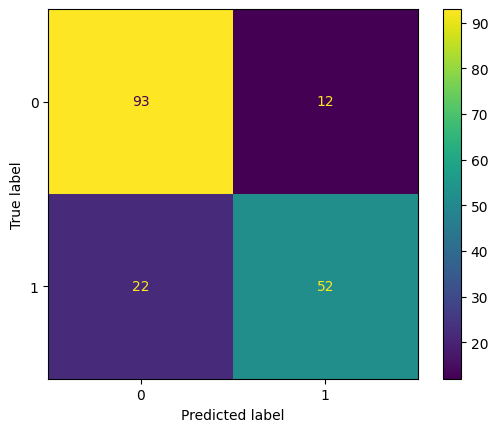

In [2344]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cf = confusion_matrix(ytest, ypred_ts)
cfd = ConfusionMatrixDisplay(cf, display_labels=c)
cfd.plot()

### Classification report

In [2345]:
from sklearn.metrics import classification_report
print(classification_report(ytest, ypred_ts))

              precision    recall  f1-score   support

           0       0.81      0.89      0.85       105
           1       0.81      0.70      0.75        74

    accuracy                           0.81       179
   macro avg       0.81      0.79      0.80       179
weighted avg       0.81      0.81      0.81       179



### Predict results for Out of sample data

In [2346]:
xnew = pd.read_csv('test_titanic.csv')
xnew.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [2347]:
pre2

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['Pclass', 'SibSp', 'Fare']),
                                ('cat',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('OHE',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['Sex'])])

### Apply pre.transform on out of sample data

In [2348]:
xnew_pre = pre2.transform(xnew)
xnew_pre.head()

,num__Pclass,num__SibSp,num__Fare,cat__Sex_female,cat__Sex_male
0,0.827377,-0.474545,-0.490783,0.0,1.0
1,0.827377,0.432793,-0.507479,1.0,0.0
2,-0.369365,-0.474545,-0.453367,0.0,1.0
3,0.827377,-0.474545,-0.474005,0.0,1.0
4,0.827377,0.432793,-0.401017,1.0,0.0


### Predict the results and probability

In [2349]:
preds = model.predict(xnew_pre)
preds

array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [2350]:
model.classes_

array([0, 1], dtype=int64)

In [2351]:
prob = model.predict_proba(xnew_pre)[:, 1]
prob[0:5]

array([0.1076231 , 0.58157469, 0.22228602, 0.10774556, 0.5835412 ])

### Save above in dataframe

In [2352]:
df_final = xnew[['PassengerId']]
df_final

,PassengerId
0,892
1,893
2,894
3,895
4,896
...,...
413,1305
414,1306
415,1307
416,1308


In [2353]:
df_final['Survived_pred']=preds 
df_final['Survived_prob']=prob

In [2354]:
df_final

,PassengerId,Survived_pred,Survived_prob
0,892,0,0.107623
1,893,1,0.581575
2,894,0,0.222286
3,895,0,0.107746
4,896,1,0.583541
...,...,...,...
413,1305,0,0.107656
414,1306,1,0.916244
415,1307,0,0.107538
416,1308,0,0.107656


### Save above results to CSV

In [2355]:
df_final.to_csv('results.csv', index=False)

### Plot how many people survived

In [2356]:
df_final['Survived_pred'].value_counts()

Survived_pred
0    269
1    149
Name: count, dtype: int64

<Axes: xlabel='Survived_pred'>

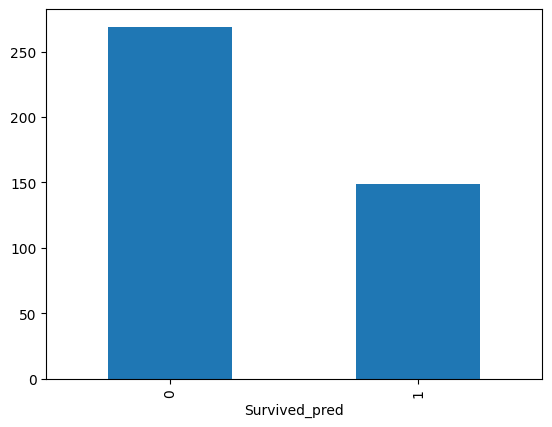

In [2357]:
df_final['Survived_pred'].value_counts().plot(kind='bar')